# Data exploration


In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import IPython.display as ipd
import os
import torch
from scipy.io import wavfile
import torchaudio
from audiosep.io import load_audio_tensor

In [2]:
idx = 1
root = "../data/train_small/"

example_dirs = sorted(
    d for d in os.listdir(root)
    if os.path.isdir(os.path.join(root, d))
)

print(f"Nombre d'exemples dans le jeu de données : {len(example_dirs)}")

folder = example_dirs[idx]
folder_path = os.path.join(root, folder)

# filenames
mix_file = [f for f in os.listdir(folder_path) if f.startswith("mix")][0]
mix_path   = os.path.join(folder_path, mix_file)
voice_path = os.path.join(folder_path, "voice.wav")
noise_path = os.path.join(folder_path, "noise.wav")

mix, sr_mix  = load_audio_tensor(mix_path)
voice, sr_voice = load_audio_tensor(voice_path)
noise, sr_noise = load_audio_tensor(noise_path)

# Normalize mix to have same peak as voice
eps = 1e-12
voice_peak = torch.max(torch.abs(voice)) + eps
mix_peak = torch.max(torch.abs(mix)) + eps
mix = mix * (voice_peak / mix_peak)   

# # Sanity check sample rates<
# print(f"Mix:   {mix.shape[1]} samples, {sr_mix} Hz, duration {mix.shape[0]/sr_mix:.2f}s")
# print(f"Voice: {voice.shape[1]} samples, {sr_voice} Hz, duration {voice.shape[0]/sr_voice:.2f}s")
# print(f"Noise: {noise.shape[1]} samples, {sr_noise} Hz, duration {noise.shape[0]/sr_noise:.2f}s") 

# Listen to each signal in the notebook
import IPython.display as ipd
print(f"Mix {mix_file}:")
ipd.display(ipd.Audio(mix, rate=sr_mix))
print(f"Voice {voice_path}:")
ipd.display(ipd.Audio(voice, rate=sr_voice))
print(f"Noise {noise_path}:")
ipd.display(ipd.Audio(noise, rate=sr_noise))  

Nombre d'exemples dans le jeu de données : 50
Mix mix_snr_0.wav:


Voice ../data/train_small/0001/voice.wav:


Noise ../data/train_small/0001/noise.wav:


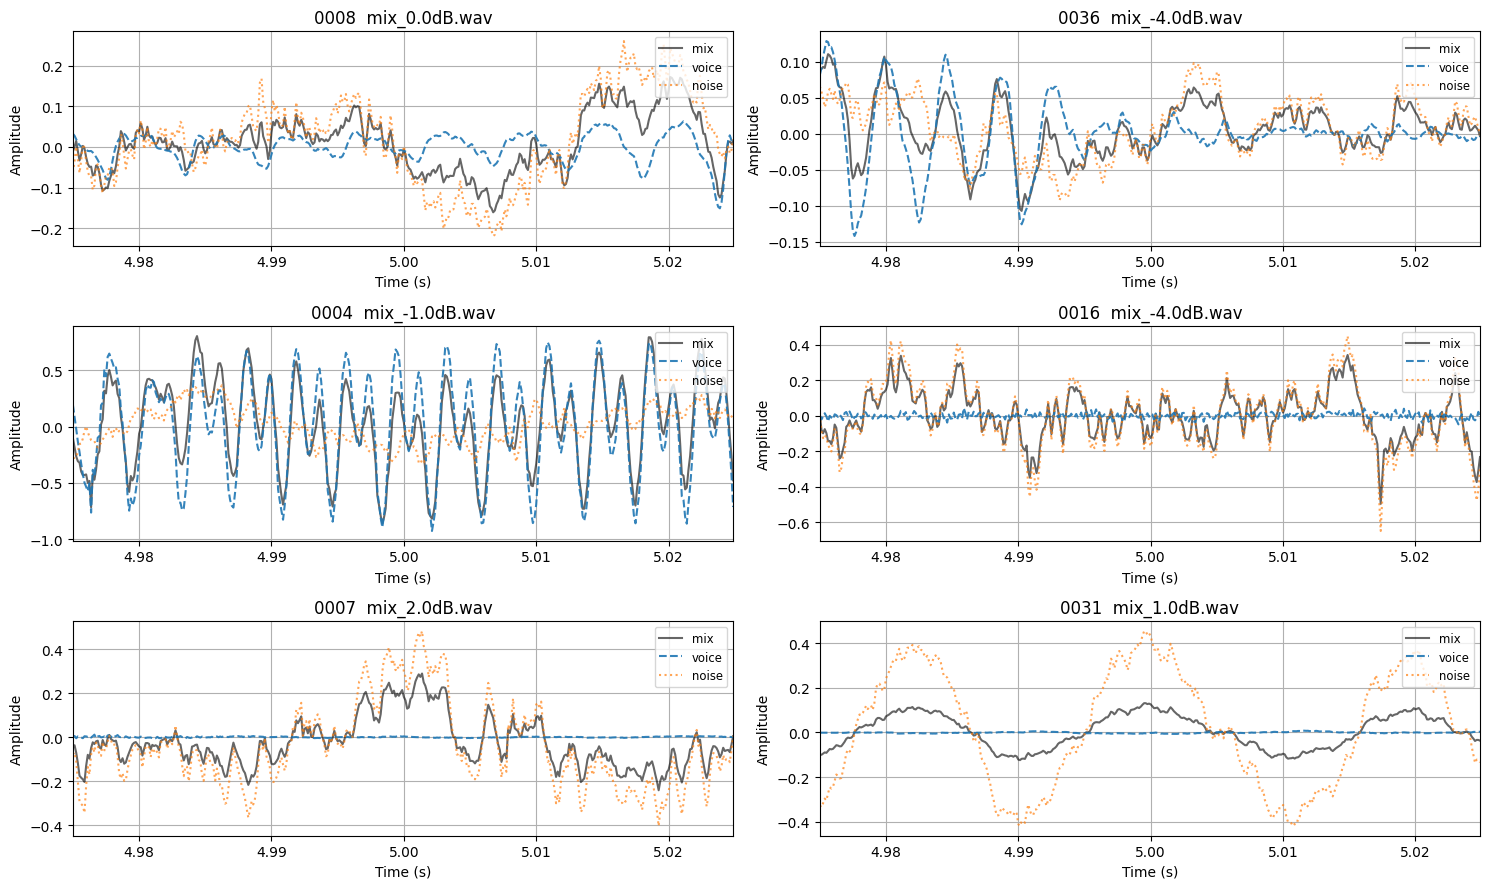

In [38]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
from audiosep.io import load_audio_tensor
import torch

root = "../data/train_small/"
n_plots = 6
win_sec = 0.05  # window length in seconds to plot

example_dirs = sorted(d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d)))
if len(example_dirs) < n_plots:
    raise RuntimeError("Not enough examples in dataset")

random.seed(1)
sel = random.sample(example_dirs, n_plots)

def _extract_snr_label(filename: str) -> str:
    m = re.search(r'(-?\d+(?:\.\d+)?)\s*[dD][bB]', filename)
    if m:
        return f"{float(m.group(1)):.1f}dB"
    m2 = re.search(r'(?:(?:^|[_\-\.\s]))(-?\d+(?:\.\d+)?)(?=$|[_\-\.\s])', filename)
    if m2:
        return f"{float(m2.group(1)):.1f}dB"
    return "n/a"

def _load_numpy(path):
    sig, sr = load_audio_tensor(path)
    # support torch tensor or numpy array, ensure 1D numpy
    if isinstance(sig, torch.Tensor):
        sig = sig.detach().cpu().numpy()
    sig = np.asarray(sig)
    if sig.ndim > 1:
        sig = sig[0]
    return sig, sr

# Preload data (one IO per file)
items = []
for folder in sel:
    fp = os.path.join(root, folder)
    mix_file = [f for f in os.listdir(fp) if f.startswith("mix")][0]
    mix_path = os.path.join(fp, mix_file)
    voice_path = os.path.join(fp, "voice.wav")
    noise_path = os.path.join(fp, "noise.wav")
    mix, sr_mix = _load_numpy(mix_path)
    voice, _ = _load_numpy(voice_path)
    noise, _ = _load_numpy(noise_path)
    items.append((folder, mix_file, mix, voice, noise, sr_mix))

# Plot grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
axes = axes.ravel()

for ax, (folder, mix_file, mix, voice, noise, sr_mix) in zip(axes, items):
    # align lengths
    min_len = min(len(mix), len(voice), len(noise))
    mix = mix[:min_len]
    voice = voice[:min_len]
    noise = noise[:min_len]
    
    # normalize
    # mix = mix / (np.max(np.abs(mix)) + eps)
    # voice = voice / (np.max(np.abs(voice)) + eps)
    # noise = noise / (np.max(np.abs(noise)) + eps)
    
    # def rms(x):
    #     return np.sqrt(np.mean(x**2) + eps)

    # mix = mix / rms(mix)
    # voice = voice / rms(voice)
    # noise = noise / rms(noise)
    
    mix = mix / (np.max(np.abs(mix)) + eps)
    voice = voice / (np.max(np.abs(voice)) + eps)
    noise = noise / (np.max(np.abs(noise)) + eps)
    
    # gain = 1.0 / (np.abs(mix).max() + 1e-8)
    # mix   = mix * gain
    # voice = voice * gain
    # noise = noise * gain
        

    # snr label from filename
    snr_label = _extract_snr_label(mix_file)
    if snr_label == "n/a":
        # fallback compute
        voice_power = np.mean(voice.astype(np.float64) ** 2)
        noise_power = np.mean(noise.astype(np.float64) ** 2)
        if noise_power <= eps:
            snr_label = "inf"
        else:
            snr_db = 10.0 * np.log10((voice_power + eps) / (noise_power + eps))
            snr_label = f"{snr_db:.1f}dB"

    # choose central window
    win_len = min(int(win_sec * sr_mix), min_len)
    start = max(0, (min_len - win_len) // 2)
    end = start + win_len
    t = np.arange(win_len) / sr_mix + start / sr_mix

    ax.plot(t, mix[start:end], label="mix", color="k", alpha=0.6)
    ax.plot(t, voice[start:end], label="voice", linestyle="--", alpha=0.9)
    ax.plot(t, noise[start:end], label="noise", linestyle=":", alpha=0.7)
    ax.set_title(f"{folder}  mix_{snr_label}.wav")
    ax.set_xlim(t[0], t[-1])
    # ax.set_ylim(-0.25, 0.25)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()

Batch size: 6
RMS dB  mean=-43.32dB  median=-42.93dB  std=1.12dB
Peak dB mean=-25.00dB  median=-25.00dB  std=0.00dB
Durations (s) mean=10.00  median=10.00


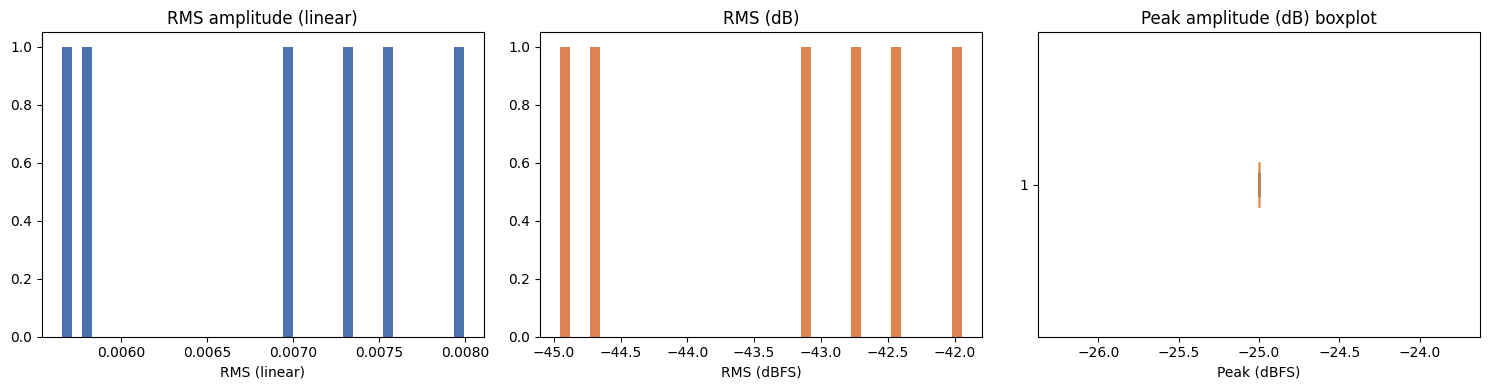

In [35]:
# ...existing code...
# Plot distribution of voice energy (RMS and peak) on a sampled batch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from audiosep.io import load_audio_tensor

root = "../data/train_small/"
batch_size = 64
eps = 1e-12

def _load_mono_numpy(path):
    sig, sr = load_audio_tensor(path)
    if isinstance(sig, torch.Tensor):
        sig = sig.detach().cpu().numpy()
    sig = np.asarray(sig)
    if sig.ndim > 1:
        sig = sig[0]
    return sig, int(sr)

# gather a batch of voice signals (reuse preloaded `items` if available)
voices = []
srs = []
if 'items' in globals() and isinstance(items, list) and len(items) > 0:
    for entry in items[:batch_size]:
        # entry format in this notebook: (folder, mix_file, mix, voice, noise, sr)
        if len(entry) >= 6:
            _, _, _, voice, _, sr = entry[:6]
            if isinstance(voice, torch.Tensor):
                voice = voice.detach().cpu().numpy()
            voices.append(np.asarray(voice).squeeze())
            srs.append(int(sr))
else:
    example_dirs = sorted(d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d)))
    sel = random.sample(example_dirs, min(batch_size, len(example_dirs)))
    for folder in sel:
        voice_path = os.path.join(root, folder, "voice.wav")
        v, sr = _load_mono_numpy(voice_path)
        voices.append(v)
        srs.append(sr)

if len(voices) == 0:
    raise RuntimeError("No voices loaded for batch analysis")

# compute RMS and peak per sample
rms_list = []
peak_list = []
durations = []
for v, sr in zip(voices, srs):
    v = np.asarray(v, dtype=np.float64)
    if v.size == 0:
        continue
    rms = np.sqrt(np.mean(v**2) + eps)
    peak = np.max(np.abs(v)) + eps
    dur = v.shape[-1] / float(sr)
    rms_list.append(rms)
    peak_list.append(peak)
    durations.append(dur)

rms_list = np.array(rms_list)
peak_list = np.array(peak_list)
rms_db = 20.0 * np.log10(rms_list + eps)
peak_db = 20.0 * np.log10(peak_list + eps)

print(f"Batch size: {len(rms_list)}")
print(f"RMS dB  mean={rms_db.mean():.2f}dB  median={np.median(rms_db):.2f}dB  std={rms_db.std():.2f}dB")
print(f"Peak dB mean={peak_db.mean():.2f}dB  median={np.median(peak_db):.2f}dB  std={peak_db.std():.2f}dB")
print(f"Durations (s) mean={np.mean(durations):.2f}  median={np.median(durations):.2f}")

# Plot histograms and boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rms_list, bins=40, color="#4c72b0")
axes[0].set_xlabel("RMS (linear)")
axes[0].set_title("RMS amplitude (linear)")

axes[1].hist(rms_db, bins=40, color="#dd8452")
axes[1].set_xlabel("RMS (dBFS)")
axes[1].set_title("RMS (dB)")

axes[2].boxplot(peak_db, vert=False, patch_artist=True,
                boxprops=dict(facecolor="#55a868"))
axes[2].set_xlabel("Peak (dBFS)")
axes[2].set_title("Peak amplitude (dB) boxplot")

plt.tight_layout()
plt.show()

# Optional KDE if seaborn is installed
try:
    import seaborn as sns
    plt.figure(figsize=(6,3))
    sns.kdeplot(rms_db, fill=True)
    plt.xlabel("RMS (dBFS)")
    plt.title("RMS (dB) KDE")
    plt.show()
except Exception:
    pass
# ...existing code...